In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/7404-Project-Demo/7404Project/Stock Price Prediction
%ls

/content/drive/MyDrive/7404-Project-Demo/7404Project/Stock Price Prediction
data/  models/  mymodels/  myplots/  requirement.txt


In [ ]:
!pip install -r requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()


In [ ]:
df = pd.read_csv("./data/Stock_Data_with_Sentiment.csv",parse_dates=True,index_col="Date")
df

,High,Low,Open,Volume,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Federal Fund Interest,Close
Date,,,,,,,,,
2009-11-02,1052.180054,1029.380005,1036.180054,6202640000,0.076001,0.874001,0.049001,0.12,1042.880005
2009-11-03,1046.359985,1033.939941,1040.920044,5487500000,0.086001,0.872001,0.042001,0.12,1045.410034
2009-11-04,1061.000000,1045.150024,1047.140015,5635510000,0.140001,0.836001,0.024001,0.13,1046.500000
2009-11-05,1066.650024,1047.300049,1047.300049,4848350000,0.097001,0.869001,0.034001,0.13,1066.630005
2009-11-06,1071.479980,1059.319946,1064.949951,4277130000,0.089001,0.864001,0.047001,0.12,1069.300049
...,...,...,...,...,...,...,...,...,...
2019-12-24,3226.429932,3220.510010,3225.449951,1296540000,0.168001,0.771001,0.061001,1.55,3223.379883
2019-12-26,3240.080078,3227.199951,3227.199951,2160680000,0.095001,0.842001,0.063001,1.55,3239.909912
2019-12-27,3247.929932,3234.370117,3247.229980,2428670000,0.053001,0.923001,0.024001,1.55,3240.020020


In [ ]:
print("--scaling data---")
data = sc.fit_transform(df)

train_ind = int(0.6*len(df))
val_ind = train_ind + int(0.2*len(df))

train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

--scaling data---


In [ ]:
print("train,test,val",train.shape, test.shape, val.shape)

xtrain,ytrain,xval,yval,xtest,ytest = train[:,:9],train[:,8],val[:,:9],val[:,8],test[:,:9],test[:,8]

lookback = 60
n_features = 9
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]


x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]


train,test,val (1534, 9) (513, 9) (511, 9)


In [ ]:
model = Sequential() 
model.add(LSTM(100,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.15))
model.add(Dense(1))
print(model.summary())
#optimizer = keras.optimizers.Adam(lr=0.000025)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 100)           44000     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 74,251
Trainable params: 74,251
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs =100, batch_size=120, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

start: 0
Train on 1474 samples, validate on 451 samples
Epoch 1/100
1474/1474 [==============================] - 3s 2ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 2/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0572 - val_loss: 0.0319
Epoch 3/100
1474/1474 [==============================] - 3s 2ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 4/100
1474/1474 [==============================] - 3s 2ms/step - loss: 0.0036 - val_loss: 2.0084e-04
Epoch 5/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 6/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0023 - val_loss: 1.7321e-04
Epoch 7/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 1.4391e-04
Epoch 9/100
1474/1474 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch

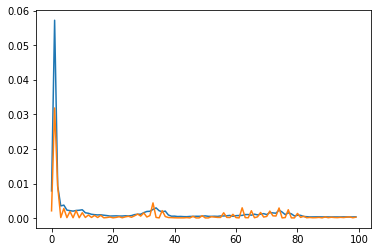

In [129]:
#model.save("/content/drive/MyDrive/models/model-vadercase3.2.h5")
loss = history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
#plt.savefig("./myplots/loss-vadercase1.jpg")
plt.show()


In [ ]:
#plt.figure(figsize=(10,3))
##plt.plot( y_test, '.-', color='blue', label='Real values', alpha=0.5)
#plt.plot( y_pred, '.-', color='red', label='Predicted values', alpha=1)
#plt.yticks(range(1500, 4800, 300))
#plt.savefig("./myplots/result-vadercase1.jpg")
#plt.title('LSTM with Sentiment Results')
#plt.legend()
#plt.show()


In [130]:
y_pred = model.predict(x_test)
y_test2 = y_test * (max(df['Close']) - min(df['Close']) ) + min(df['Close'])
y_pred2 = y_pred * (max(df['Close']) - min(df['Close']) ) + min(df['Close'])

In [131]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test2, y_pred2)

32.480224609375

In [132]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test2, y_pred2)

4999.401206082531

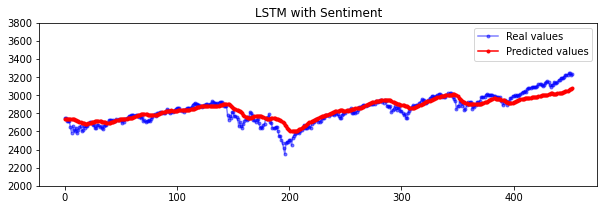

In [133]:
plt.figure(figsize=(10,3))
plt.plot( y_test2, '.-', color='blue', label='Real values', alpha=0.5)
plt.plot( y_pred2, '.-', color='red', label='Predicted values', alpha=1)
plt.yticks(range(2000, 4000, 200))
#plt.savefig("./myplots/result-vadercase1.jpg")
plt.title('LSTM with Sentiment')
plt.legend()
plt.show()